In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model

# import yfinance as yf
# import pandas_datareader.data as web
# from datetime import datetime, timedelta 
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [4]:
returns = df['Log Return'] * 100

In [5]:
obs = returns[2000:]

In [6]:
am = arch_model(obs, vol='Garch', p=2, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2015-02-20")

In [7]:
res

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                        Log Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4920.10
Distribution:      Standardized Skew Student's t   AIC:                           9854.21
Method:                       Maximum Likelihood   BIC:                           9897.44
                                                   No. Observations:                 3555
Date:                           Sun, Mar 26 2023   Df Residuals:                     3554
Time:                                   13:29:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [8]:
forecasts = res.forecast(start="2015-02-23", reindex=False)
cond_mean = forecasts.mean["2015-02-23":]
cond_var = forecasts.variance["2015-02-23":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.69302527 -1.68539129]


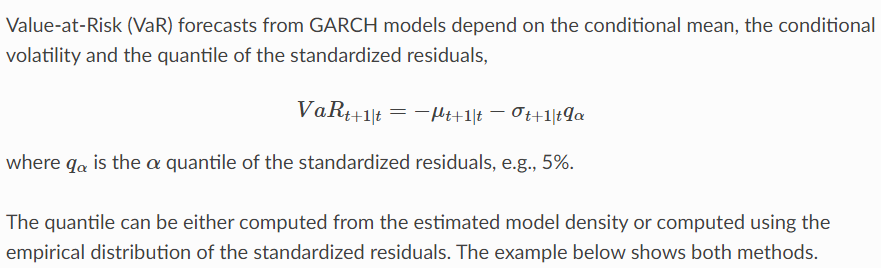

In [9]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index) * -1
value_at_risk['return'] = returns

In [10]:
(value_at_risk['return'] < value_at_risk['1%']).value_counts(normalize=True)

False    0.9875
True     0.0125
dtype: float64

In [11]:
(value_at_risk['return'] < value_at_risk['5%']).value_counts(normalize=True)

False    0.9495
True     0.0505
dtype: float64

In [25]:
x_axis = value_at_risk.index
VaR = value_at_risk['5%']

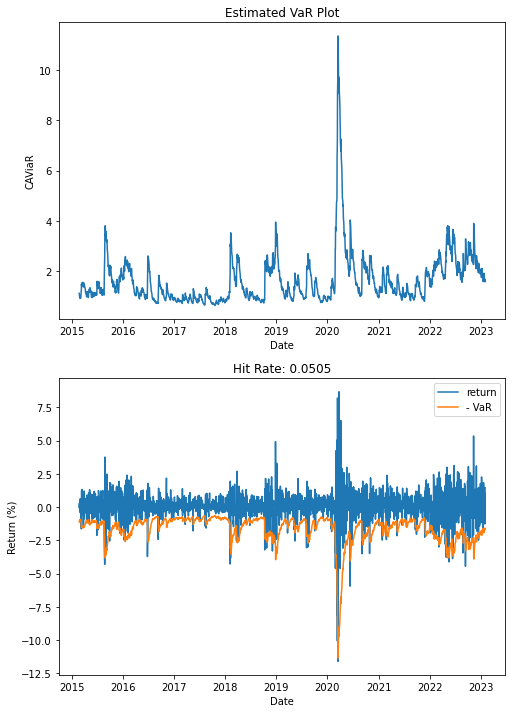

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6*2))
    
axes[0].plot(x_axis, -VaR)
axes[0].set_title(f'Estimated VaR Plot')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('CAViaR')

axes[1].plot(x_axis, value_at_risk['return'], label='return')
axes[1].plot(x_axis, VaR, label='- VaR')
hit = sum(value_at_risk['return'] < VaR) / len(value_at_risk['return'])
axes[1].set_title(f'Hit Rate: {hit:.4f}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(f'Return (%)')
axes[1].legend()

plt.show()

In [27]:
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test

In [28]:
# H0: the obs ~ binomial(p)

print(binomial_test(value_at_risk['return'], VaR, 0.05))

0.9182286528479413


In [29]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(value_at_risk['return'], VaR, 0.05))

1.0


..\var_tests\_test.py:44: RuntimeWarning: divide by zero encountered in log
  LR_POF = -2 * np.log(numerator / denominator)


In [30]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(value_at_risk['return'], VaR))

0.9591730957811068


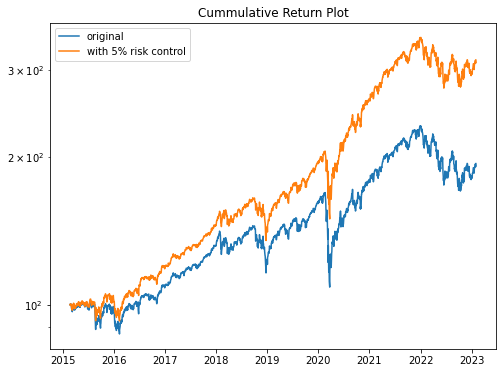

In [31]:
ntl = 100
penalty = 0.002
quantile = 0.05

backtest_df = pd.DataFrame({
    'ret': value_at_risk['return'] / 100,
    'low/open': out_low_open_log_difference,
    'VaR': VaR / 100
})

original = ntl * (1 + backtest_df.ret).cumprod()

new = (1 + np.maximum(backtest_df['ret'], backtest_df['VaR']))
new = new * ((backtest_df['low/open'] < backtest_df['VaR']) * -penalty + 1)
new = ntl * new.cumprod()

plt.figure(figsize=(8, 6))
plt.plot(original, label='original')
plt.plot(new, label=f'with {int(quantile*100)}% risk control')
plt.title('Cummulative Return Plot')
plt.legend()
plt.yscale('log')
plt.show()